In [1]:
import pandas as pd
import os
import random

import os
import time
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import random
from collections import defaultdict

import multiprocessing
from functools import partial
import parmap
from datetime import datetime

pd.set_option('display.max_columns', 500)

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'

csv_file_path = os.path.join(data_dir, 'train_data.csv')
test_file_path = os.path.join(data_dir, 'test_data.csv')

df = pd.read_csv(csv_file_path, parse_dates=['Timestamp'])
tdf = pd.read_csv(test_file_path, parse_dates=['Timestamp'])

df = pd.concat([df, tdf]).reset_index(drop=True)

In [22]:
# df_all을 이용하여, df에 통계량을 추가
def generate_mean_std(df, df_all, x):
    x_mean = df_all.groupby(x)['answerCode'].mean().reset_index()
    x_std = df_all.groupby(x)['answerCode'].std().reset_index()

    x_mean = {key:value for key, value in x_mean.values}
    x_std = {key:value for key, value in x_std.values}

    df_mean = df[x].apply(lambda x: x_mean[x])
    df_std = df[x].apply(lambda x: x_std[x])

    return df_mean, df_std

In [8]:
# train과 test를 합친 통계량 (test 데이터에서 -1인 데이터는 제외)
df_train = pd.read_csv(os.path.join('/opt/ml/input/data/train_dataset', 'train_data.csv')) 
df_test = pd.read_csv(os.path.join('/opt/ml/input/data/train_dataset', 'test_data.csv')) 
df_test = df_test.loc[df_test.answerCode!=-1]
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

# 난이도에 대한 column 추가
df['difficulty'] = df['assessmentItemID'].apply(lambda x:x[1:4])
df_all['difficulty'] = df_all['assessmentItemID'].apply(lambda x:x[1:4])

In [6]:
# 4개 행에 대한 mean, std 통계량 column 추가
df['difficulty_mean'], df['difficulty_std'] = generate_mean_std(df, df_all, 'difficulty')
df['testId_mean'], df['testId_std'] = generate_mean_std(df, df_all, 'testId')
df['assessmentItemID_mean'], _ = generate_mean_std(df, df_all, 'assessmentItemID')
df['KnowledgeTag_mean'], df['KnowledgeTag_std'] = generate_mean_std(df, df_all, 'KnowledgeTag')

In [7]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,difficulty,difficulty_mean,difficulty_std,testId_mean,testId_std,assessmentItemID_mean,KnowledgeTag_mean,KnowledgeTag_std
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,060,0.712279,0.452701,0.952667,0.212422,0.984000,0.957333,0.202239
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,060,0.712279,0.452701,0.952667,0.212422,0.968000,0.917067,0.275818
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,060,0.712279,0.452701,0.952667,0.212422,0.916000,0.917067,0.275818
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,060,0.712279,0.452701,0.952667,0.212422,0.972000,0.917067,0.275818
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,060,0.712279,0.452701,0.952667,0.212422,0.948000,0.917067,0.275818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,040,0.680256,0.466378,0.640427,0.480035,0.436667,0.638385,0.480557
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,040,0.680256,0.466378,0.640427,0.480035,0.483333,0.638385,0.480557
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,040,0.680256,0.466378,0.640427,0.480035,0.846667,0.765442,0.423899
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,040,0.680256,0.466378,0.640427,0.480035,0.830000,0.765442,0.423899


In [8]:
# 문제 풀이에 걸린 시간을 카테고리형으로 범주화
def get_character(x):
    if x < 0:
        return 'A'
    elif x < 23:
        return 'B'
    elif x < 56:
        return 'C'
    elif x < 68:
        return 'D'
    elif x < 84:
        return 'E'
    elif x < 108:
        return 'F'
    elif x < 4*60:
        return 'G'
    elif x < 24*60*60:
        return 'H'
    else:
        return 'I'
    
def convert_time(s):
    timestamp = datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple()
    return timestamp

In [9]:
# 문제 풀이에 걸린 시간을 더 세세한 카테고리형으로 범주화
def get_character_detail(x):
    if x < 0:
        return 'A'
    elif x < 2:
        return 'B'
    elif x < 10:
        return 'C'
    elif x < 23:
        return 'D'
    elif x < 56:
        return 'E'
    elif x < 68:
        return 'F'
    elif x < 84:
        return 'G'
    elif x < 108:
        return 'I'
    elif x < 4*60:
        return 'J'
    elif x < 10 * 60:
        return 'K'
    elif x < 24*60*60:
        return 'L'
    elif x < 24*60*60*7:
        return 'M'
    else:
        return 'N'

In [10]:
# userid 별로 character, week_number, mday, hour column 생성
# outlier: 유저별 마지막 문항(다음 문항이 없어 문제 풀이 시간을 구할 수 없다.)
def process_by_userid(x, grouped):
    gp = grouped.get_group(int(x))
    gp = gp.sort_values(by=['userID','Timestamp'] ,ascending=True)
    tmp = gp['Timestamp'].astype(str)
    gp['Timestamp'] = tmp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    gp['time'] = gp['Timestamp'].shift(-1, fill_value=datetime.strptime('1970-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'))
    gp['time'] = gp['time'] - gp['Timestamp']
    gp['time'] = gp['time'].apply(lambda x:int(x.total_seconds()))
    
    gp['duration_outlier_mean'] = gp['time'].apply(lambda x: x if x >= 0 else gp['time'][(gp['time'] <= 4*60) & (gp['time'] >= 0)].mean())
    gp['character_outlier_mean'] = gp['time'].apply(get_character)
    gp['duration_outlier_median'] = gp['time'].apply(lambda x: x if x >= 0 else gp['time'][(gp['time'] <= 4*60) & (gp['time'] >= 0)].median())
    gp['character_outlier_median'] = gp['time'].apply(get_character)
    
    gp['character_detail_outlier_mean'] = gp['time'].apply(get_character_detail)
    gp['character_detail_outlier_median'] = gp['time'].apply(get_character_detail)

    timetuple = tmp.apply(convert_time)
    gp['week_number'] = gp['Timestamp'].apply(lambda x:x.isocalendar()[1]) # 해당 년도의 몇번째 주인지
    gp['mday'] = timetuple.apply(lambda x:x.tm_wday) # 요일
    gp['hour'] = timetuple.apply(lambda x:x.tm_hour) # 시간

    return gp.drop(['time'], axis=1)

In [7]:
# userid 별로 character, week_number, mday, hour column 생성
grouped = df.groupby(df.userID)
final_df = sorted(list(df['userID'].unique()))
final_df = parmap.map(partial(process_by_userid, grouped = grouped), 
                              final_df, pm_pbar = True, pm_processes = multiprocessing.cpu_count())
processed_df = pd.concat(final_df).reset_index(drop=True)

In [12]:
# 유저별로 시험지의 시작과 끝 index 추가
def make_max_min_idx(x, group):
    df = group.get_group(x).reset_index(drop=True)

    testid = df.loc[0, 'testId']
    index = []

    for idx in range(len(df)):
        if testid != df.loc[idx, 'testId']:
            df.loc[index, 'max_index'] = index[-1] + 1
            df.loc[index, 'min_index'] = index[0]
            index = [idx]
            testid = df.loc[idx, 'testId']
        else:
            index.append(idx)

    df.loc[index, 'max_index'] = index[-1] + 1
    df.loc[index, 'min_index'] = index[0]
    
    return df

In [31]:
# 유저별로 시험지의 시작과 끝 index 추가
processed_df['max_index'] = 0
processed_df['min_index'] = 0
processed_df = parmap.map(partial(make_max_min_idx, group = processed_df.groupby('userID')), processed_df['userID'].unique(), pm_pbar=True, pm_processes = multiprocessing.cpu_count())
processed_df = pd.concat(processed_df).reset_index(drop=True)

In [23]:
# KnowledgeTag, assessmentItemID cnt column 추가
def make_cnt(df, df_all, column):
    dic = df_all.groupby('testId').agg({
        column:'nunique'
    }).reset_index()

    dic = {key:value for key, value in dic.values}
    return df['testId'].apply(lambda x:dic[x])

In [25]:
# KnowledgeTag, assessmentItemID cnt column 추가
processed_df['KnowledgeTag_cnt'] = make_cnt(processed_df, df_all, 'KnowledgeTag')
processed_df['assessmentItemID_cnt'] = make_cnt(processed_df, df_all, 'assessmentItemID')

In [ ]:
# processed_df 저장
# processed_df.to_csv('/opt/ml/p4-dkt-DKTJHGSD/code/output/processed_df.csv', index=False)

In [26]:
# time series를 고려한 feature들 추가, user의 개인 점수 추가
def add_own_features(x, group, past_answer=3, past_testid=3, days=28):
    gp = group.get_group(int(x)).reset_index(drop=True)
    s = 0
    e = gp.loc[s, 'max_index']
    gp['testId_own_mean'] = 0
    
    for i in range(1, past_answer + 1):
        gp[f'past_OX_{i}'] = 0
        gp[f'past_KnowledgeTag_{i}'] = -1
        gp[f'past_duration_mean_{i}'] = -1
        gp[f'past_duration_median_{i}'] = -1
        gp[f'past_character_mean_{i}'] = -1
        gp[f'past_character_median_{i}'] = -1
        gp[f'past_character_detail_mean_{i}'] = -1
        gp[f'past_character_detail_median_{i}'] = -1
    
    for i in range(1, past_testid + 1):
        gp[f'past_testid_{i}'] = -1
        gp[f'past_testid_{i}_mean'] = 0
        gp[f'past_testid_{i}_std'] = 0
        gp[f'past_testid_{i}_own'] = 0
    
    temp = []
    
    while True:
        try:
            gp.loc[s:e-1, 'testId_own_mean'] = gp.loc[s:e-2, 'answerCode'].mean()
            for i in range(1, past_answer + 1):
                if e - i - 1 >= gp.loc[e-1, 'min_index']:
                    gp.loc[e-1, f'past_OX_{i}'] = gp.loc[e-i-1, 'answerCode'] + 1
                    gp.loc[e-1, f'past_KnowledgeTag_{i}'] = gp.loc[e-i-1, 'KnowledgeTag']
                    gp.loc[e-1, f'past_duration_mean_{i}'] = gp.loc[e-i-1, 'duration_outlier_mean']
                    gp.loc[e-1, f'past_duration_median_{i}'] = gp.loc[e-i-1, 'duration_outlier_median']
                    gp.loc[e-1, f'past_character_mean_{i}'] = gp.loc[e-i-1, 'character_outlier_mean']
                    gp.loc[e-1, f'past_character_median_{i}'] = gp.loc[e-i-1, 'character_outlier_median']
                    gp.loc[e-1, f'past_character_detail_mean_{i}'] = gp.loc[e-i-1, 'character_detail_outlier_mean']
                    gp.loc[e-1, f'past_character_detail_median_{i}'] = gp.loc[e-i-1, 'character_detail_outlier_median']
                else:
                    break
            
            temp_idx = gp.loc[e-1, 'min_index'] - 1
            current_time = gp.loc[e-1, 'Timestamp']
            
            for i in range(1, past_testid + 1):
                if temp_idx >= 0 and (current_time - gp.loc[temp_idx, 'Timestamp']).days <= days:
                    gp.loc[e-1, f'past_testid_{i}'] = gp.loc[temp_idx, 'testId']
                    gp.loc[e-1, f'past_testid_{i}_mean'] = gp.loc[temp_idx, 'testId_mean']
                    gp.loc[e-1, f'past_testid_{i}_std'] = gp.loc[temp_idx, 'testId_std']
                    gp.loc[e-1, f'past_testid_{i}_own'] = gp.loc[temp_idx, 'testId_own_mean']
                    temp_idx = gp.loc[temp_idx, 'min_index'] - 1
                else:
                    break
                    
            temp.append(gp.loc[e-1:e-1])
            s = gp.loc[s, 'max_index']
            e = gp.loc[s, 'max_index']
        except:
            break
    
    return pd.concat(temp)

In [32]:
# time series를 고려한 feature들 추가, user의 개인 점수 추가
own_df = parmap.map(partial(add_own_features,
                            group=processed_df.groupby('userID'),
                            past_answer=5, # 직전 문제에 대한 정보 개수
                            past_testid=10, # 직전 testid에 대한 정보 개수
                            days=28), # testid에 대한 정보를 만들 때, 몇 일 이내의 정보를 쓸건지
                    processed_df['userID'].unique(),
                    pm_pbar=True,
                    pm_processes = multiprocessing.cpu_count())
own_df = pd.concat(own_df).reset_index(drop=True)

In [6]:
# own_df = pd.read_csv('/opt/ml/p4-dkt-DKTJHGSD/code/output/own_df.csv')
own_df['difficulty'] = own_df['assessmentItemID'].apply(lambda x:x[1:4])

In [10]:
# 마지막 문제인지, 몇 월에 풀었는지
last_prob = df_all.groupby('testId').agg({
    'assessmentItemID':'max'
}).reset_index()

dic = {key:value for key, value in last_prob.values}
own_df['is_last'] = (own_df['testId'].apply(lambda x:dic[x]) == own_df['assessmentItemID']).astype(int) # 해당 문제가 그 시험지의 마지막 문제인가
own_df['month'] = own_df['Timestamp'].astype(str).apply(lambda x:x[5:7]) # 몇 월달에 풀었는지

In [40]:
# 직전 testid 들과의 시간 차이
def time_lap(x, group, past_testid=10, days=28):
    gp = group.get_group(int(x))
    
    for i in range(1, 1 + past_testid):
        gp[f'past_testid_{i}_timelap'] = 0
    
    for i in range(1, 1 + past_testid):
        gp[f'past_testid_{i}_timelap'] = (gp['Timestamp'] - gp['Timestamp'].shift(i, fill_value=0)).apply(lambda x:x.days if x.days <= days else 18345)
        
    return gp

In [54]:
# 직전 testid 들과의 시간 차이
own_df['Timestamp'] = own_df['Timestamp'].astype('datetime64[s]')
own_df = parmap.map(partial(time_lap, group=own_df.groupby('userID'), past_testid=10, days=28), own_df['userID'].unique(), pm_pbar=True, pm_processes = multiprocessing.cpu_count())
own_df = pd.concat(own_df).reset_index(drop=True)

In [44]:
# 해당 유저의 normalize_score 추가
own_df['normalize_score'] = (own_df['testId_own_mean'] - own_df['testId_mean']) / own_df['testId_std']

for i in range(1, 11):
    own_df[f'past_testid_{i}_normalize_score'] = (own_df[f'past_testid_{i}_own'] - own_df[f'past_testid_{i}_mean']) / own_df[f'past_testid_{i}_std']
    own_df[f'past_testid_{i}_normalize_score'].fillna(-10000, inplace=True)

In [50]:
# KnowledgeTag의 뒤 두 자리를 제외한 tag를 대분류로 판별
own_df['tag_test'] = own_df['KnowledgeTag'].astype(str).apply(lambda x:x[:-2] if len(x) > 2 else 0)

# 과거 시험지들의 KnowledgeTag의 맨뒤 두 자리를 제외한 tag를 대분류로 판별
df['tag_test'] = df['KnowledgeTag'].astype(str).apply(lambda x:x[:-2] if len(x) > 2 else 0).astype(int)

tag_stack = df.groupby('testId').agg({
    'tag_test':'unique'
}).reset_index()

testid_tag_cnt = df.groupby(['testId', 'tag_test']).agg({
    'assessmentItemID':'nunique'
}).reset_index()

record = defaultdict(defaultdict)

for testid, tag, cnt in testid_tag_cnt.values:
    record[testid][tag] = cnt
    
tmp_list = []
for tid, tags in tag_stack.values:
    tmp_list.append(sorted(tags, key=lambda x:record[tid][x], reverse=True))
    
tag_stack['tag_sorted'] = tmp_list

dic = {}
for tid, tags in tag_stack[['testId', 'tag_sorted']].values:
    dic[tid] = tags
    
from tqdm.auto import tqdm

# testid에서 상위 3개 big_tag 추가
for i in range(1, 11):
    for j in range(1, 4):
        own_df[f'past_testid_{i}_tag_{j}'] = -1

def make_testid_tag(tid, idx):
    if tid != '-1' and idx < len(dic[tid]):
        return dic[tid][idx]
    else:
        return -1
    
for i in tqdm(range(1, 11)):
    for j in range(1, 4):
        own_df[f'past_testid_{i}_tag_{j}'] = own_df[f'past_testid_{i}'].apply(partial(make_testid_tag, idx=j - 1))

In [64]:
# own_df 저장
own_df.to_csv('/opt/ml/p4-dkt-DKTJHGSD/code/output/own_df.csv', index=False)

In [54]:
# category column type casting
cate = sum([['testId', 'assessmentItemID', 'KnowledgeTag', 'character_outlier_mean', 'character_outlier_median', 'character_detail_outlier_mean'],
            ['character_detail_outlier_median', 'week_number', 'mday', 'hour', 'difficulty', 'KnowledgeTag_cnt', 'assessmentItemID_cnt', 'month', 'is_last', 'tag_test'],
            [f'past_OX_{i}' for i in range(1, 6)],
            [f'past_KnowledgeTag_{i}' for i in range(1, 6)],
            [f'past_testid_{i}' for i in range(1, 11)],
            [f'past_testid_{i}_tag_{j}' for i in range(1, 11) for j in range(1, 4)],
            [f'past_character_mean_{i}' for i in range(1, 6)],
            [f'past_character_median_{i}' for i in range(1, 6)],
            [f'past_character_detail_mean_{i}' for i in range(1, 6)],
            [f'past_character_detail_median_{i}' for i in range(1, 6)]
           ], [])

for c in cate:
    own_df[c] = own_df[c].astype('category')

In [55]:
# inference에 사용하는 data와, train에 사용하는 data 분류
ttt = own_df[own_df['answerCode'] == -1].reset_index(drop=True) # inference에 사용
dfdf = own_df[own_df['answerCode'] != -1].reset_index(drop=True) # train에 사용

In [56]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, ratio=0.7, split=True):
    random.seed(42)
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    
    user_ids = []

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [57]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

# 유저별 분리
train, test = custom_train_test_split(dfdf, ratio=0.7)

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [60]:
# 하이퍼 파라미터와 결과 기록을 위한 dict
result = {}
config = {}
cnt = 0

In [61]:
import math

# 여러 feature 중에서 원하는 feature를 선택, 하이퍼 파라미터도 탐색
for past_ox in [4]:
    for past_testid in [5]:
        FEATS = sum([['assessmentItemID',
              'testId',
              'KnowledgeTag',
#               'difficulty',
#               'testId_mean',
              'normalize_score',
              'assessmentItemID_mean',
#               'character_outlier_median',
#               'character_outlier_mean',
#               'character_detail_outlier_median',
              'character_detail_outlier_mean',
              'week_number',
#               'testId_own_mean',
              'mday',
              'hour',
              'tag_test',
#               'duration_outlier_median',
              'duration_outlier_mean',
             ],
             [f'past_OX_{i}' for i in range(1, 1 + past_ox)],
             [f'past_KnowledgeTag_{i}' for i in range(1, 1 + past_ox)],
#              [f'past_character_median_{i}' for i in range(1, 1 + past_ox)],
#              [f'past_character_mean_{i}' for i in range(1, 1 + past_ox)],
#              [f'past_character_detail_median_{i}' for i in range(1, 1 + past_ox)],
             [f'past_character_detail_mean_{i}' for i in range(1, 1 + past_ox)],
#              [f'past_duration_median_{i}' for i in range(1, 1 + past_ox)],
             [f'past_duration_mean_{i}' for i in range(1, 1 + past_ox)],
             [f'past_testid_{i}' for i in range(1, 1 + past_testid)],
#              [f'past_testid_{i}_mean' for i in range(1, 1 + past_testid)],
             [f'past_testid_{i}_timelap' for i in range(1, 1 + past_testid)],
#              [f'past_testid_{i}_own' for i in range(1, 1 + past_testid)],
             [f'past_testid_{i}_normalize_score' for i in range(1, 1 + past_testid)],
             [f'past_testid_{i}_tag_{j + 1}' for i in range(1, 1 + past_testid) for j in range(2)]
            ],
            [])


        lgb_train = lgb.Dataset(train[FEATS], y_train)
        lgb_test = lgb.Dataset(test[FEATS], y_test)

        
        for max_depth in [8]:
            for num_leaves in [64]:
#                 print(f'feat_frac:{feat_frac}, bag_frac:{bag_frac}')
                params = {'learning_rate': 0.01,
                          'max_depth':max_depth,
                          'boosting': 'gbdt',
                          'objective': 'binary',
                          'metric': 'auc',
                #           'is_training_metric': True,
                          'num_leaves': num_leaves - 1,
                          'feature_fraction': 1,
                          'bagging_fraction': 1,
                          'bagging_freq': 5,
                          'seed':42,
                #           'device':'cpu',
                         }

                model = lgb.train(
                                    params, 
                                    lgb_train,
                                    valid_sets=[lgb_train, lgb_test],
                                    verbose_eval=-1,
                                    num_boost_round=20000,
                                    early_stopping_rounds=100
                                )

                preds = model.predict(test[FEATS])
                acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
                auc = roc_auc_score(y_test, preds)

                print(f'VALID AUC : {auc} ACC : {acc}\n')
                
                result[cnt] = {'AUC':auc, 'ACC':acc}
                config[cnt] = {'FEATS':FEATS, 'params':params}

[LightGBM] [Info] Number of positive: 163712, number of negative: 128018
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18969
[LightGBM] [Info] Number of data points in the train set: 291730, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561176 -> initscore=0.245938
[LightGBM] [Info] Start training from score 0.245938


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[691]	training's auc: 0.892782	valid_1's auc: 0.849599
VALID AUC : 0.8495991315186361 ACC : 0.7695749440715883



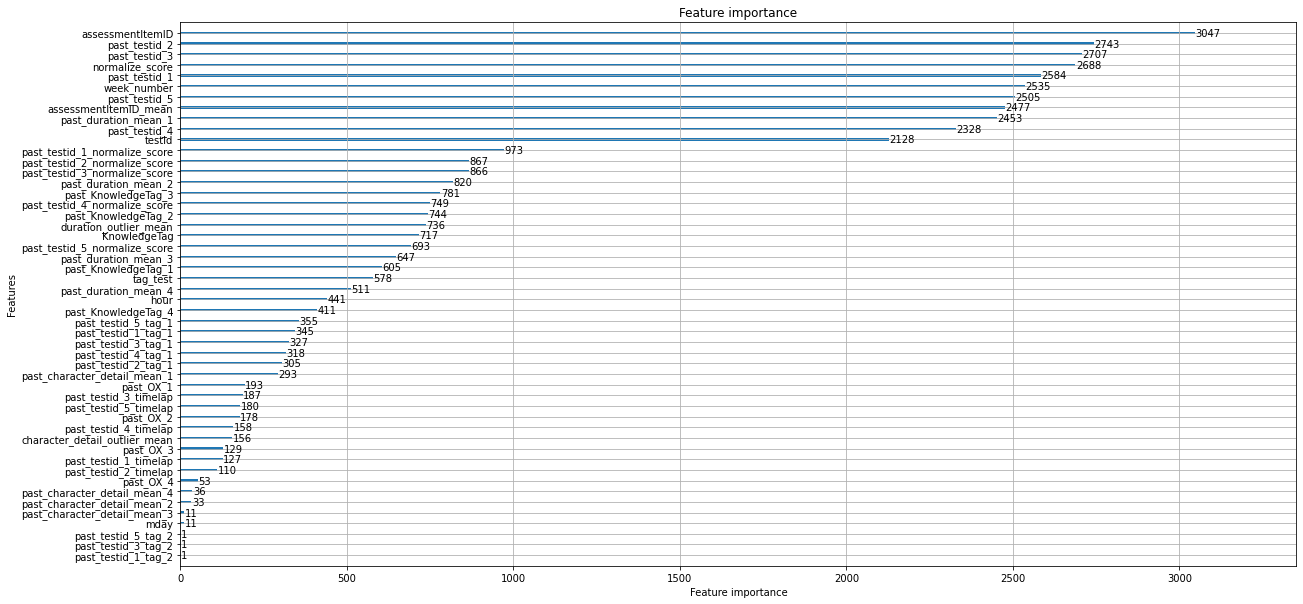

In [65]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model, figsize=(20, 10))

In [70]:
print(sorted(result, key=lambda x:[result[x]['AUC'], result[x]['ACC']], reverse=True)[:20])

[0]


In [72]:
config[0]

{'FEATS': ['assessmentItemID',
  'testId',
  'KnowledgeTag',
  'normalize_score',
  'assessmentItemID_mean',
  'character_detail_outlier_mean',
  'week_number',
  'mday',
  'hour',
  'tag_test',
  'duration_outlier_mean',
  'past_OX_1',
  'past_OX_2',
  'past_OX_3',
  'past_OX_4',
  'past_KnowledgeTag_1',
  'past_KnowledgeTag_2',
  'past_KnowledgeTag_3',
  'past_KnowledgeTag_4',
  'past_character_detail_mean_1',
  'past_character_detail_mean_2',
  'past_character_detail_mean_3',
  'past_character_detail_mean_4',
  'past_duration_mean_1',
  'past_duration_mean_2',
  'past_duration_mean_3',
  'past_duration_mean_4',
  'past_testid_1',
  'past_testid_2',
  'past_testid_3',
  'past_testid_4',
  'past_testid_5',
  'past_testid_1_timelap',
  'past_testid_2_timelap',
  'past_testid_3_timelap',
  'past_testid_4_timelap',
  'past_testid_5_timelap',
  'past_testid_1_normalize_score',
  'past_testid_2_normalize_score',
  'past_testid_3_normalize_score',
  'past_testid_4_normalize_score',
  'past_

In [73]:
# inference
total_preds = model.predict(ttt[FEATS])

In [622]:
# Save
output_dir = '/opt/ml/p4-dkt-DKTJHGSD/code/output'
write_path = os.path.join(output_dir, "output_fold.csv")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/p4-dkt-DKTJHGSD/code/output/output_fold.csv
